**Before you start**<br>
Change runtime type to GPU <br>
Runtime > Change runtime type > GPU > Save

Install fastai

In [1]:
!pip install -Uqq fastbook
from fastai.vision.all import *
# from IPython.display import Image 

In [2]:
# Point script at data
path = Path('/media/nick/4TB Working/Projects/cloud detection/training data')
path

Path('/media/nick/4TB Working/Projects/cloud detection/training data')

In [3]:
# define model name
model_name = 'cloud_model'

In [4]:
# make sure things look correct
path.ls()

(#4) [Path('/media/nick/4TB Working/Projects/cloud detection/training data/classes.csv'),Path('/media/nick/4TB Working/Projects/cloud detection/training data/cloud'),Path('/media/nick/4TB Working/Projects/cloud detection/training data/models'),Path('/media/nick/4TB Working/Projects/cloud detection/training data/no_cloud')]

In [68]:
# set model settings
batch_size = 4
img_size = 500

In [81]:
# define image transforms
item_tfms = [Resize(img_size)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size, flip_vert=True,max_rotate=90.0,max_lighting=0.1,
                            min_zoom=0.8, max_zoom=1.3, max_warp=0,                             
                            )]


In [82]:
# load data
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,splitter=RandomSplitter(seed=42),
                                    bs=batch_size,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms
                                   )


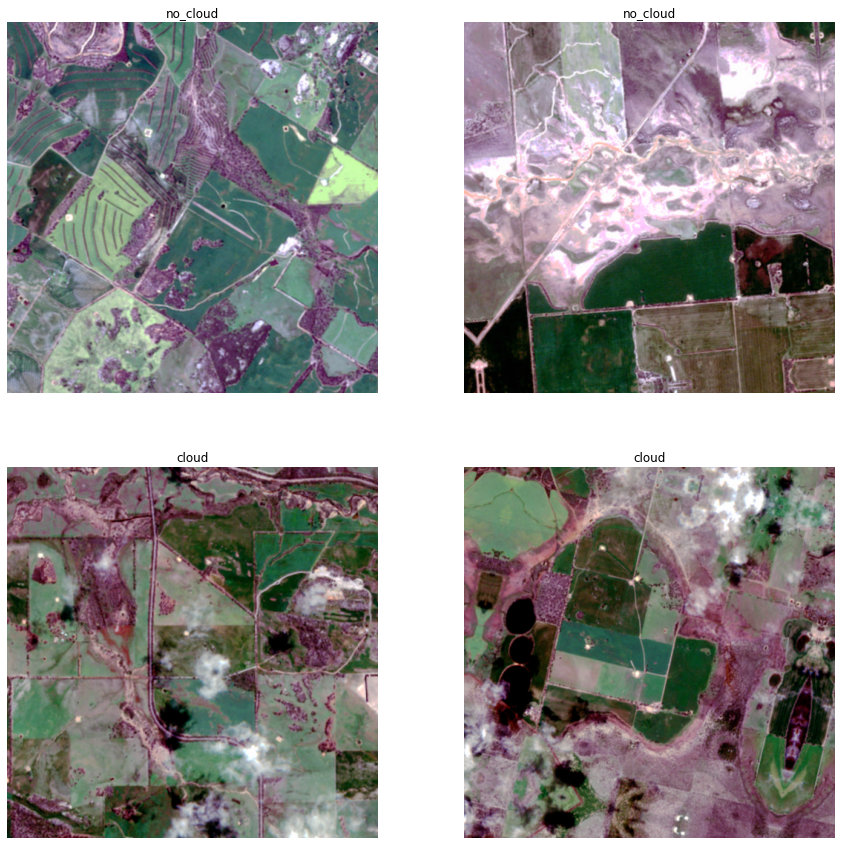

In [112]:
# Check data
data.show_batch(max_n = 9, figsize = (15,15))

In [113]:
# save classes to txt file
np.savetxt(path/'classes.csv', np.array(data.vocab), fmt='%s')

In [86]:
# make model
learn = cnn_learner(data, resnet18, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time
0,0.591596,0.052433,0.011765,00:03


Better model found at epoch 0 with error_rate value: 0.0117647061124444.


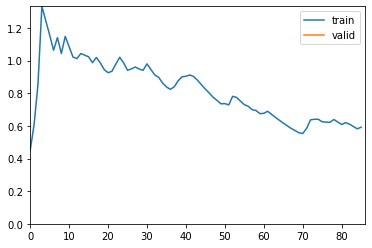

epoch,train_loss,valid_loss,error_rate,time
0,0.273157,0.013058,0.000000,00:03
1,0.375392,0.003211,0.000000,00:03
2,0.343273,0.002972,0.000000,00:03


Better model found at epoch 0 with error_rate value: 0.0.


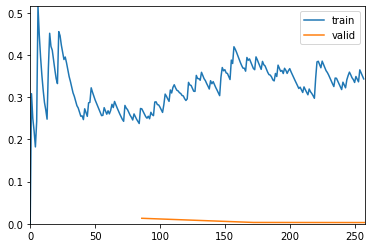

In [87]:
# train model
learn.fine_tune(3,cbs = [ShowGraphCallback(),
                         SaveModelCallback(monitor='error_rate',with_opt=True, fname=model_name)])


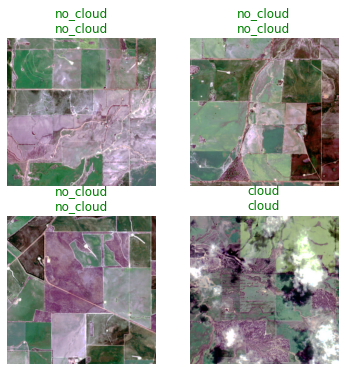

In [88]:
# check the outputs
learn.show_results()

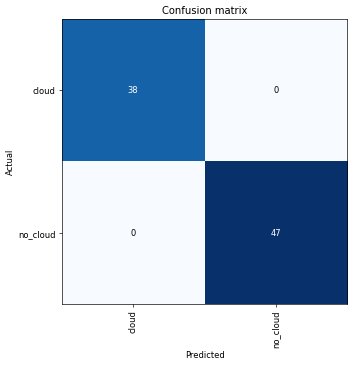

In [90]:
# check confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [91]:
# export model to disk
learn.export('models/'+model_name+'.pkl')

# Infernce

In [93]:
# install some GIS tools
!pip install geopandas
!pip install rasterio

In [94]:
# import more tools
# GIS
import geopandas as gpd
import rasterio
from shapely.geometry import box
# system
from multiprocessing import Pool
from tqdm.auto import tqdm

In [95]:
# point this at the tiled data
input_raster_path = '/media/nick/4TB Working/Projects/cloud detection/Cloud_Detection_test_data/202109050217_S2B_MSI_ESA_50HNH_432_chunks'
# this is the output file path
export_vector_path = input_raster_path+'.gpkg'
export_vector_path

'/media/nick/4TB Working/Projects/cloud detection/Cloud_Detection_test_data/202109050217_S2B_MSI_ESA_50HNH_432_chunks.gpkg'

In [96]:
# read calsses from text file
classes = np.loadtxt(path/'classes.csv',delimiter='\n', dtype=str)
classes

array(['cloud', 'no_cloud'], dtype='<U8')

In [97]:
# find all files and grab the CRS of one of them
input_rasters = []

for root, dirs, files in os.walk(input_raster_path):
    for file in files:
        if file.endswith('.tif'):
            input_rasters.append(os.path.join(root, file))

dataset = rasterio.open(input_rasters[0])
crs = dataset.crs
            
print('File count',len(input_rasters))
print('CRS',crs)

file count 729
CRS EPSG:3857


In [98]:
# load model setup up data and pushes to GPU
learn_inf = load_learner(path/str('models/'+model_name+'.pkl'))
learn_inf.dls.cuda()
dl = learn_inf.dls.test_dl(input_rasters,device='cuda',bs=batch_size)

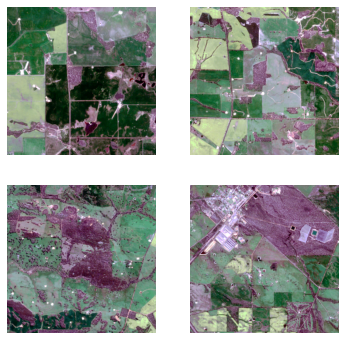

In [99]:
# display a batch
dl.show_batch()

In [100]:
# run model
pred_scores,none,pred_class_int = learn_inf.get_preds(dl=dl,with_decoded=True)

In [114]:
pred_class_int

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# use rasterio to open every raster and extract its extent
def get_bounds(raster):
    try:
        dataset = rasterio.open(raster)
        bounds = dataset.bounds
        geom = box(*bounds)
    except:
        print(raster)
    return geom

In [142]:
# loop over data and save into list as dict
pred_dict_list = []
for pred_int,file_path,pred_score in zip(pred_class_int,input_rasters,pred_scores.cpu().detach().numpy()):
#     build dict for each image
    pred_dict = {'path':file_path,
                'pred_class':classes[pred_int],
                 'geometry':get_bounds(file_path)
                 }
#     add n number of class preds
    for class_name in classes:
        pred_index = list(classes).index(class_name)
        pred_dict[class_name] = pred_score[pred_index]
        
    pred_dict_list.append(pred_dict)

In [151]:
# build list of dicts into dataframe
preds_gdf = gpd.GeoDataFrame(pred_dict_list,crs=crs,geometry='geometry')

<AxesSubplot:>

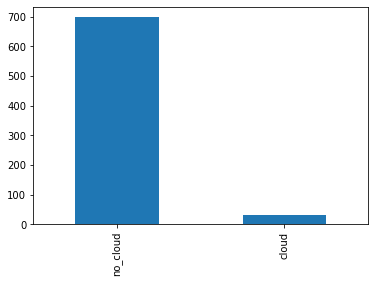

In [152]:
# plot distrobution
fig, ax = plt.subplots()
preds_gdf['pred_class'].value_counts().plot(ax=ax, kind='bar')

In [153]:
# export vector file
preds_gdf.to_file(export_vector_path, driver="GPKG")